In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical

from resnet_builder.resnet import ResnetBuilder

### Build ResNet 1D

In [19]:
res_1d = ResnetBuilder(name="ResNet18", mode="1D")
res_1d(Input((12,10)))
res_1d.summary()

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_2 (Conv_st (None, 3, 64)             4800      
_________________________________________________________________
conv_basic_block_4 (Conv_bas (None, 3, 64)             21440     
_________________________________________________________________
identity_basic_block_12 (Ide (None, 3, 64)             25216     
_________________________________________________________________
conv_basic_block_5 (Conv_bas (None, 2, 128)            66944     
_________________________________________________________________
identity_basic_block_13 (Ide (None, 2, 128)            99584     
_________________________________________________________________
conv_basic_block_6 (Conv_bas (None, 1, 256)            264960    
_________________________________________________________________
identity_basic_block_14 (Ide (None, 1, 256)            395

### Build ResNet50 2D

In [20]:
res_2d = ResnetBuilder(name="ResNet50", mode="2D")
res_2d(Input((32,32,3)))
res_2d.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_3 (Conv_st (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_bottleneck_block_4 (Con (None, 8, 8, 256)         75392     
_________________________________________________________________
identity_bottleneck_block_29 (None, 8, 8, 256)         71552     
_________________________________________________________________
identity_bottleneck_block_30 (None, 8, 8, 256)         71552     
_________________________________________________________________
conv_bottleneck_block_5 (Con (None, 4, 4, 512)         381184    
_________________________________________________________________
identity_bottleneck_block_31 (None, 4, 4, 512)         282368    
_________________________________________________________________
identity_bottleneck_block_32 (None, 4, 4, 512)         282

### Build Time Distributed ResNet34 with GroupNorm
norm = "GroupNrom" means using GroupNormalization instead of BatchNormalization

In [21]:
res_2d = ResnetBuilder(name="ResNet34", mode="TimeD", norm="GroupNorm")
res_2d(Input((5, 32,32,3)))
res_2d.summary()

Model: "ResNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_4 (Conv_st (None, 5, 8, 8, 64)       9600      
_________________________________________________________________
conv_basic_block_8 (Conv_bas (None, 5, 8, 8, 64)       45632     
_________________________________________________________________
identity_basic_block_16 (Ide (None, 5, 8, 8, 64)       74112     
_________________________________________________________________
identity_basic_block_17 (Ide (None, 5, 8, 8, 64)       74112     
_________________________________________________________________
conv_basic_block_9 (Conv_bas (None, 5, 4, 4, 128)      164736    
_________________________________________________________________
identity_basic_block_18 (Ide (None, 5, 4, 4, 128)      295680    
_________________________________________________________________
identity_basic_block_19 (Ide (None, 5, 4, 4, 128)      295

### Build ResNet 3D

In [22]:
res_3d = ResnetBuilder(name="ResNet101", mode="3D")
res_3d(Input((50, 32,32,3)))
res_3d.summary()

Model: "ResNet101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_5 (Conv_st (None, 13, 8, 8, 64)      66176     
_________________________________________________________________
conv_bottleneck_block_8 (Con (None, 13, 8, 8, 256)     149120    
_________________________________________________________________
identity_bottleneck_block_41 (None, 13, 8, 8, 256)     145280    
_________________________________________________________________
identity_bottleneck_block_42 (None, 13, 8, 8, 256)     145280    
_________________________________________________________________
conv_bottleneck_block_9 (Con (None, 7, 4, 4, 512)      676096    
_________________________________________________________________
identity_bottleneck_block_43 (None, 7, 4, 4, 512)      577280    
_________________________________________________________________
identity_bottleneck_block_44 (None, 7, 4, 4, 512)      57

# Demo with CIFAR10

In [25]:
# CIFAR 10 Information
class_num = 10
img_size = 32
ch_num = 3

In [26]:
# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# Convert class vectors to binary class matrices.
Y_train = to_categorical(y_train, class_num)
Y_test = to_categorical(y_test, class_num)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [27]:
def flip_image(image):
    return tf.image.random_flip_left_right(image)

In [28]:
# random crop shift range
shift_range = 0.1
expand_target_size = int(img_size*(shift_range+1))
def image_shift(image):
    # padding
    image = tf.image.resize_with_crop_or_pad(
                    image,
                    expand_target_size,
                    expand_target_size
                    )
    #random crop
    image = tf.image.random_crop(
                    image,
                    size=[img_size, img_size, ch_num]
                    )
    return image

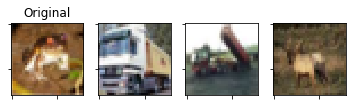

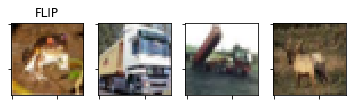

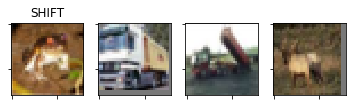

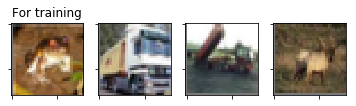

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_images(iterator, desc):
    for i in range(4):
        img = next(iterator)
        img = (img.numpy()*128. + mean_image).astype(np.uint8)
        if i == 1: plt.title(desc)
        plt.subplot(1,4,i+1)
        plt.tick_params(
                labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
        plt.imshow(img)  
    plt.show()

input_ds = tf.data.Dataset.from_tensor_slices(X_train)
show_images(iter(input_ds), "Original")
show_images(iter(input_ds.map(flip_image)), "FLIP")
show_images(iter(input_ds.map(image_shift)), "SHIFT")
show_images(iter(input_ds.map(flip_image).map(image_shift)), "For training")

In [30]:
iterator = iter(input_ds.batch(10))
x = next(iterator)
print(".batch x1 : ", x.shape)

iterator = iter(input_ds.batch(5).batch(10))
x = next(iterator)
print(".batch x2 : ", x.shape)

.batch x1 :  (10, 32, 32, 3)
.batch x2 :  (10, 5, 32, 32, 3)


# Training

In [31]:
batch_size = 32
# create train dataset
input_ds = tf.data.Dataset.from_tensor_slices(X_train)
input_ds = input_ds.map(flip_image).map(image_shift)
target_ds = tf.data.Dataset.from_tensor_slices(Y_train)
train_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(batch_size).repeat()

# create test
input_ds = tf.data.Dataset.from_tensor_slices(X_test)
target_ds = tf.data.Dataset.from_tensor_slices(Y_test)
test_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(batch_size).repeat()

# ResNet18
model = ResnetBuilder(name="ResNet18", mode="2D",include_top=True, class_num=10)
model(Input((32,32,3)))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_6 (Conv_st (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_12 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_28 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_13 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_29 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_14 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_30 (Ide (None, 2, 2, 256)         118

In [32]:
# fit method
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
tb_callback = tf.keras.callbacks.TensorBoard("./tb_logdir", histogram_freq=1)
model.fit(train_ds, 
                steps_per_epoch=int(np.floor(X_train.shape[0]/batch_size)),
                validation_data=test_ds,
                validation_steps=int(np.floor(X_test.shape[0]/batch_size)),
                epochs=200, 
                verbose=1,
                callbacks=[lr_reducer, early_stopper, tb_callback]
                )

Train for 1562 steps, validate for 312 steps
Epoch 1/200
1562/1562 [==============================] - 47s 30ms/step - loss: 1.6714 - accuracy: 0.4621 - val_loss: 1.1584 - val_accuracy: 0.5870
Epoch 2/200
1562/1562 [==============================] - 40s 26ms/step - loss: 1.0839 - accuracy: 0.6172 - val_loss: 0.9966 - val_accuracy: 0.6489
Epoch 3/200
1562/1562 [==============================] - 40s 26ms/step - loss: 0.9388 - accuracy: 0.6718 - val_loss: 0.9196 - val_accuracy: 0.6772
Epoch 4/200
1562/1562 [==============================] - 40s 26ms/step - loss: 0.8382 - accuracy: 0.7075 - val_loss: 0.8089 - val_accuracy: 0.7160
Epoch 5/200
1562/1562 [==============================] - 41s 26ms/step - loss: 0.7567 - accuracy: 0.7345 - val_loss: 0.8285 - val_accuracy: 0.7092
Epoch 6/200
1562/1562 [==============================] - 40s 25ms/step - loss: 0.6929 - accuracy: 0.7598 - val_loss: 0.7414 - val_accuracy: 0.7481
Epoch 7/200
1562/1562 [==============================] - 40s 25ms/step - 

## Faster dataset setting

In [33]:
# ResNet18
model2 = ResnetBuilder(name="ResNet18", mode="2D",include_top=True, class_num=10)
model2(Input((32,32,3)))
model2.summary()
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_7 (Conv_st (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_16 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_32 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_17 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_33 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_18 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_34 (Ide (None, 2, 2, 256)         118

In [34]:
# create train dataset
input_ds = tf.data.Dataset.from_tensor_slices(X_train)
input_ds = input_ds.map(flip_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
input_ds = input_ds.map(image_shift, num_parallel_calls=tf.data.experimental.AUTOTUNE)
target_ds = tf.data.Dataset.from_tensor_slices(Y_train)
train_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(batch_size).repeat()

# create test
input_ds = tf.data.Dataset.from_tensor_slices(X_test)
target_ds = tf.data.Dataset.from_tensor_slices(Y_test)
test_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(batch_size).repeat()

In [35]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6,verbose=1)
early_stopper = EarlyStopping(verbose=1, patience=10)
model2.fit(train_ds, 
                steps_per_epoch=int(np.floor(X_train.shape[0]/batch_size)),
                validation_data=test_ds,
                validation_steps=int(np.floor(X_test.shape[0]/batch_size)),
                epochs=200, 
                verbose=1,
                callbacks=[lr_reducer, early_stopper]
                )

Train for 1562 steps, validate for 312 steps
Epoch 1/200
1562/1562 [==============================] - 32s 20ms/step - loss: 1.6230 - accuracy: 0.4743 - val_loss: 1.1318 - val_accuracy: 0.6004
Epoch 2/200
1562/1562 [==============================] - 27s 17ms/step - loss: 1.0758 - accuracy: 0.6246 - val_loss: 1.0429 - val_accuracy: 0.6401
Epoch 3/200
1562/1562 [==============================] - 28s 18ms/step - loss: 0.9327 - accuracy: 0.6741 - val_loss: 0.9690 - val_accuracy: 0.6707
Epoch 4/200
1562/1562 [==============================] - 28s 18ms/step - loss: 0.8255 - accuracy: 0.7116 - val_loss: 0.8178 - val_accuracy: 0.7186
Epoch 5/200
1562/1562 [==============================] - 27s 17ms/step - loss: 0.7468 - accuracy: 0.7403 - val_loss: 0.7687 - val_accuracy: 0.7416
Epoch 6/200
1562/1562 [==============================] - 28s 18ms/step - loss: 0.6844 - accuracy: 0.7606 - val_loss: 0.7150 - val_accuracy: 0.7582
Epoch 7/200
1562/1562 [==============================] - 27s 17ms/step - 